
# Analyser les relations bivariées entre séries financières

Ce notebook couvre :
1. **Mesurer et visualiser la corrélation** (matrice + heatmap)
2. **Corrélations robustes** (Spearman, Kendall)
3. **Régression simple CAPM (express)**
4. **Tableau de contingence** & **test d'indépendance**
5. **Comparer deux groupes** (test t de Welch)
6. **Comparer plusieurs groupes** (ANOVA + Kruskal)
7. **Défi & solution**


In [1]:
%pip install yfinance --quiet
%pip install scipy --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats


## Paramètres & téléchargement des données

In [3]:

UNIVERSE = ["META", "AAPL", "MSFT", "JPM", "BAC", "C", "XOM", "CVX"]
MARKET_TICKER = "^GSPC"
START_DATE = "2020-01-01"
END_DATE = None

data = yf.download(UNIVERSE + [MARKET_TICKER], start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

if isinstance(data.columns, pd.MultiIndex):
    prices = data["Adj Close"].copy()
else:
    prices = data[["Adj Close"]].copy()

prices = prices.dropna(how="all")
market_prices = prices[MARKET_TICKER].dropna()
asset_prices = prices.drop(columns=[MARKET_TICKER], errors="ignore").dropna(how="all")

asset_prices.head()


Ticker,AAPL,BAC,C,CVX,JPM,META,MSFT,XOM
Date,,,,,,,,
2020-01-02,72.538536,30.920324,65.700386,93.955635,120.154686,208.635406,152.791153,54.131065
2020-01-03,71.833298,30.278328,64.462906,93.630653,118.569107,207.531464,150.888596,53.695869
2020-01-06,72.405678,30.234943,64.260696,93.313423,118.474815,211.440048,151.278641,54.108166
2020-01-07,72.065147,30.035406,63.702618,92.121849,116.460655,211.897491,149.899307,53.665344
2020-01-08,73.224403,30.339066,64.187912,91.069588,117.369148,214.045731,152.286942,52.856052


## Rendements journaliers

In [4]:

asset_r = asset_prices.pct_change().dropna(how="all")
market_r = market_prices.pct_change().dropna()
asset_r = asset_r.loc[asset_r.index.intersection(market_r.index)]
market_r = market_r.loc[asset_r.index]
asset_r.head()


Ticker,AAPL,BAC,C,CVX,JPM,META,MSFT,XOM
Date,,,,,,,,
2020-01-03,-0.009722,-0.020763,-0.018835,-0.003459,-0.013196,-0.005291,-0.012452,-0.008040
2020-01-06,0.007968,-0.001433,-0.003137,-0.003388,-0.000795,0.018834,0.002585,0.007678
2020-01-07,-0.004703,-0.006600,-0.008685,-0.012770,-0.017001,0.002163,-0.009118,-0.008184
2020-01-08,0.016086,0.010110,0.007618,-0.011422,0.007801,0.010138,0.015928,-0.015080
2020-01-09,0.021241,0.001715,0.009072,-0.001615,0.003652,0.014311,0.012493,0.007656


Ticker,AAPL,BAC,C,CVX,JPM,META,MSFT,XOM
Ticker,,,,,,,,
AAPL,1.000,0.431,0.436,0.347,0.427,0.560,0.719,0.294
BAC,0.431,1.000,0.872,0.624,0.889,0.336,0.424,0.583
C,0.436,0.872,1.000,0.634,0.851,0.354,0.429,0.585
CVX,0.347,0.624,0.634,1.000,0.621,0.221,0.328,0.857
JPM,0.427,0.889,0.851,0.621,1.000,0.330,0.434,0.557
META,0.560,0.336,0.354,0.221,0.330,1.000,0.626,0.161
MSFT,0.719,0.424,0.429,0.328,0.434,0.626,1.000,0.240
XOM,0.294,0.583,0.585,0.857,0.557,0.161,0.240,1.000


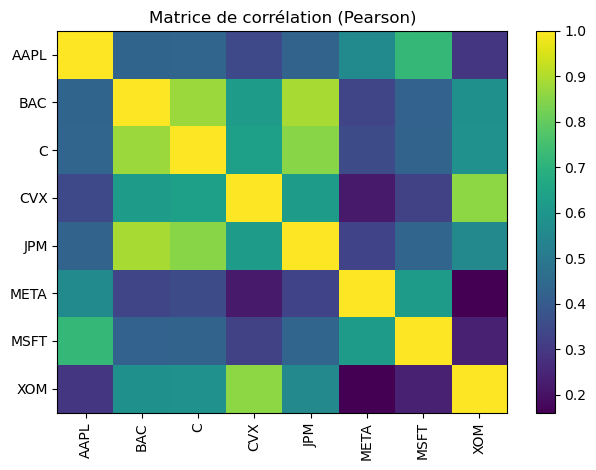

In [5]:

corr_pearson = asset_r.corr(method="pearson")
display(corr_pearson.round(3))

plt.figure()
plt.imshow(corr_pearson, aspect='auto', interpolation='nearest')
plt.title("Matrice de corrélation (Pearson)")
plt.xticks(range(len(corr_pearson.columns)), corr_pearson.columns, rotation=90)
plt.yticks(range(len(corr_pearson.index)), corr_pearson.index)
plt.colorbar()
plt.tight_layout()
plt.show()


## 2) Corrélations robustes (Spearman, Kendall) — Matrice & Heatmap

Les corrélations **non paramétriques** de **Spearman** et **Kendall** évaluent la **dépendance monotone** entre deux séries (ex. rendements), sans exiger de linéarité ni de normalité.  
Elles sont **moins sensibles aux valeurs extrêmes** que Pearson, donc mieux adaptées à des données financières **asymétriques** et **à queues épaisses**.  



### Définition
- **Spearman (ρₛ)** : corrélation de Pearson **appliquée aux rangs** des observations.  
  On remplace chaque valeur par son rang, puis on calcule Pearson sur ces rangs.  
- **Kendall (τᵦ)** : basée sur les **paires concordantes/discordantes** ;  
  τ = P(concordance) − P(discordance), avec **τᵦ** qui corrige les ex aequo.  
- Les coefficients varient de **−1 à +1** (même lecture générale que Pearson).  
  **|τᵦ| est souvent plus faible que |ρₛ|** pour un même signal — c’est normal.  



### Conditions d’utilisation
- Variables **ordinales ou continues** (rendements) **alignées** sur les mêmes dates.  
- Relation attendue **monotone** (croissante ou décroissante), pas forcément linéaire.  
- Mesures **robustes aux outliers** ; prévoir un **nettoyage/winsorisation légère** si nécessaire.  
- Si beaucoup d’**ex aequo**, privilégier **Kendall τᵦ**.  



### Limites
- Ne captent pas les **relations non monotones** (ex. en U).  
- **Kendall** est **plus coûteuse** à calculer sur de grands univers d’actifs.  
- Les amplitudes sont **moins “spectaculaires”** que Pearson : comparez **méthodes entre elles**, pas les valeurs brutes.  


### Interprétation en finance
- **Spearman/Kendall élevées** → actifs évoluant **monotoniquement ensemble** → diversification réduite.  
- **Proches de 0** → dépendance faible/instable → diversification potentiellement meilleure.  
- En **marchés stressés**, ces mesures restent souvent **plus stables** que Pearson face aux chocs extrêmes.  
- La **heatmap** met en évidence des **blocs** (secteurs, devises, maturités) utiles pour la construction de portefeuille.  


👉 **En résumé**  
- Utilisez **Spearman** comme alternative robuste par défaut.  
- Ajoutez **Kendall τᵦ** en cas de nombreux **ex aequo** ou de petit échantillon.  
- Comparez la matrice robuste à **Pearson**, suivez la **stabilité temporelle** (fenêtres roulantes) et **masquez les corrélations non significatives**.  


In [6]:

corr_spearman = asset_r.corr(method="spearman")
corr_kendall = asset_r.corr(method="kendall")
display(corr_spearman.round(3))
display(corr_kendall.round(3))


Ticker,AAPL,BAC,C,CVX,JPM,META,MSFT,XOM
Ticker,,,,,,,,
AAPL,1.000,0.299,0.308,0.202,0.315,0.531,0.667,0.184
BAC,0.299,1.000,0.835,0.499,0.850,0.298,0.279,0.490
C,0.308,0.835,1.000,0.486,0.805,0.316,0.307,0.478
CVX,0.202,0.499,0.486,1.000,0.481,0.126,0.145,0.872
JPM,0.315,0.850,0.805,0.481,1.000,0.300,0.305,0.461
META,0.531,0.298,0.316,0.126,0.300,1.000,0.638,0.105
MSFT,0.667,0.279,0.307,0.145,0.305,0.638,1.000,0.096
XOM,0.184,0.490,0.478,0.872,0.461,0.105,0.096,1.000


Ticker,AAPL,BAC,C,CVX,JPM,META,MSFT,XOM
Ticker,,,,,,,,
AAPL,1.000,0.208,0.215,0.139,0.222,0.381,0.494,0.126
BAC,0.208,1.000,0.656,0.354,0.674,0.206,0.193,0.347
C,0.215,0.656,1.000,0.344,0.625,0.218,0.214,0.339
CVX,0.139,0.354,0.344,1.000,0.343,0.086,0.099,0.701
JPM,0.222,0.674,0.625,0.343,1.000,0.207,0.214,0.327
META,0.381,0.206,0.218,0.086,0.207,1.000,0.470,0.071
MSFT,0.494,0.193,0.214,0.099,0.214,0.470,1.000,0.064
XOM,0.126,0.347,0.339,0.701,0.327,0.071,0.064,1.000


## 3) Régression simple CAPM (express)

Le CAPM relie le rendement d’un actif au facteur de marché pour estimer deux paramètres clés :
- **Bêta (β)** : sensibilité de l’actif aux mouvements du marché (risque systématique).
- **Alpha (α)** : surperformance ajustée du risque, non expliquée par le marché.



### Préparer les données (express)
1. Aligner les séries sur les **mêmes dates**.
2. Utiliser des **rendements périodiques** cohérents (journalier, hebdo ou mensuel).
3. Calculer les **rendements en excès** : rendement de l’actif moins taux sans risque, et rendement du marché moins taux sans risque.
4. Nettoyer les **valeurs extrêmes** (winsorisation légère) et supprimer les valeurs manquantes.



### Étapes d’estimation (sans formule)
1. Effectuer une **régression linéaire** des rendements en excès de l’actif sur ceux du marché en incluant une constante.
2. Relever **alpha**, **bêta**, les **statistiques t**, les **p-values** et le **R²**.
3. Vérifier les **résidus** (autocorrélation, hétéroscédasticité) et, si besoin, utiliser des **erreurs robustes**.
4. **Annualiser** alpha si nécessaire (ex. données mensuelles) en utilisant une approximation simple ou une composition sur la période.
5. Visualiser un **nuage de points** “marché en excès” vs “actif en excès” et la **droite d’ajustement**.



### Interprétation rapide
- **Bêta > 1** : actif plus sensible que le marché ; **bêta < 1** : moins sensible ; **bêta négatif** : évolution inverse au marché.
- **Alpha positif et significatif** : surperformance non expliquée par le marché (à challenger).
- **R² élevé** : part importante de la variance expliquée par le facteur marché.


### Bonnes pratiques
- Garder une **périodicité homogène** (ne pas mélanger des fréquences).
- Tester la **stabilité dans le temps** (bêtas roulants).
- Détecter les **points de levier** et **outliers** via diagnostics.
- Préférer des **erreurs robustes** pour séries financières.
- Compléter au besoin par des **modèles multifactoriels** (size, value, momentum, qualité, etc.).



### Limites
- Modèle **monofacteur** : ne capture pas toutes les sources de risque/rendement.
- **Ruptures de régime** possibles (paramètres non stables).
- Sensibilité au **choix du proxy de marché** et du **taux sans risque**.



### Livrables attendus
- Tableau : **alpha**, **bêta**, **t-stats**, **p-values**, **R²**, **alpha annualisé**.
- Graphique : **nuage de points** (rendements en excès) + **droite d’ajustement**.
- **Paragraphe d’analyse** : lecture de bêta, significativité d’alpha, qualité d’ajustement, stabilité et pistes multi-facteurs.


,alpha,beta,R2,p_value_beta
META,0.0005,1.3249,0.4043,0.0


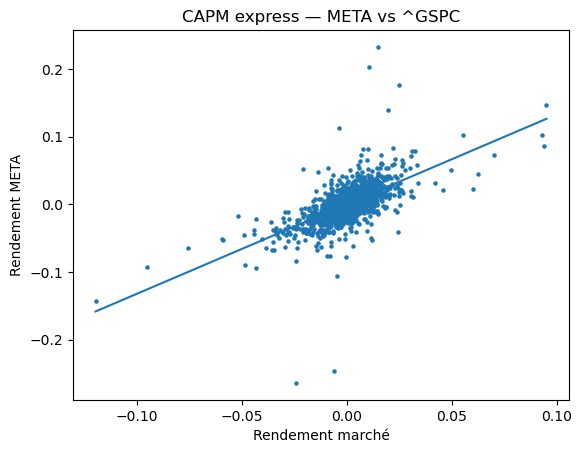

In [7]:

TARGET = "META"
y = asset_r[TARGET].dropna()
x = market_r.loc[y.index]

res = stats.linregress(x, y)
alpha, beta, r2 = res.intercept, res.slope, res.rvalue**2

summary = pd.DataFrame({
    "alpha":[alpha], "beta":[beta], "R2":[r2], "p_value_beta":[res.pvalue]
}, index=[TARGET])
display(summary.round(4))

plt.figure()
plt.scatter(x, y, s=5)
x_line = np.linspace(x.min(), x.max(), 100)
plt.plot(x_line, alpha + beta * x_line)
plt.title(f"CAPM express — {TARGET} vs {MARKET_TICKER}")
plt.xlabel("Rendement marché")
plt.ylabel(f"Rendement {TARGET}")
plt.show()


## 4) Tableau de contingence & test Chi-deux

Le **tableau de contingence** croise deux variables **catégorielles** (ou des variables continues **discrétisées**) pour résumer leurs effectifs communs.  
Le **test du Chi-deux d’indépendance** vérifie si la **répartition** observée dans le tableau est compatible avec l’**indépendance** entre les deux variables.



### Quand l’utiliser ?
- Vérifier si un **événement** dépend d’un **groupe** (ex. défaut vs tranche de score PD).  
- Comparer la **distribution** d’une classe sur plusieurs **périodes** (ex. hausse/baisse vs jour de la semaine).  
- Contrôler si des **segments** (secteurs, pays, notations) présentent des **comportements différents** (rendements up/down, volatilité faible/forte, etc.).  
- En risque de crédit : **défaut/non-défaut** vs **bandes de PD**, **rating** vs **migration** (test d’homogénéité).



### Données & préparation
1. **Deux variables catégorielles** (ou continues discrétisées en classes pertinentes).  
2. **Nettoyer** les valeurs manquantes et s’assurer d’un **échantillon suffisant**.  
3. **Règle pratique** pour le Chi-deux :  
   - éviter des effectifs **attendus** trop faibles (idéalement ≥ 5 dans au moins 80 % des cellules, et aucun attendu < 1).  
4. Pour les variables continues (rendements, PD…), définir des **seuils** ou **quantiles** (attention au sur-découpage).



### Hypothèses
- **H0 (indépendance)** : la distribution de la variable A ne dépend pas des modalités de B.  
- **H1 (association)** : il existe une dépendance entre A et B.



### Procédure pas à pas
1. **Construire** le tableau de contingence (lignes = modalités de A, colonnes = modalités de B).  
2. **Calculer** les effectifs **attendus** (ce que l’on observerait sous indépendance) et comparer aux **observés**.  
3. **Obtenir** la statistique du test Chi-deux, les **degrés de liberté** ( = (lignes − 1) × (colonnes − 1) ) et la **p-value**.  
4. **Décider** : si p-value < α (ex. 0,05), **rejeter H0** → association significative.  
5. **Diagnostiquer** les cellules qui “portent” le résultat via les **résidus standardisés** (|résidu| > 2 ~ contribution notable).



### Taille d’effet & post-hoc
- **V de Cramér** (0 → 1) : force de l’association (interprétation courante)  
  - ≈ 0,10 : faible | ≈ 0,30 : moyenne | ≈ 0,50 : forte (repères usuels)  
- **Phi (φ)** : équivalent du V de Cramér pour les tableaux **2×2**.  
- **Post-hoc** : comparer des **proportions par paires** (ou lire les **résidus standardisés**) avec **correction des multiples tests** (Bonferroni, Benjamini–Hochberg).


### Cas particuliers & variantes
- **2×2, petits effectifs** : préférer le **test exact de Fisher** (plus fiable que Chi-deux).  
- **2×2, effectifs modérés** : on rencontre parfois la **correction de continuité de Yates** (prudence, peut être conservatrice).  
- **Grande dimension** : le **G-test** (rapport de vraisemblance) est une alternative au Chi-deux.



### Visualisations utiles
- **Heatmap** des **résidus standardisés** (met en évidence les cellules sur-/sous-représentées).  
- **Mosaic plot** (surface proportionnelle aux effectifs, lecture visuelle des associations).  
- **Barres empilées / 100 %** par modalité (comparaison de profils).



### Pièges à éviter
- **Découpage arbitraire** (trop de classes → effectifs faibles, résultats instables).  
- **Multiplicité** non contrôlée (beaucoup de tests sans correction).  
- **Échantillons déséquilibrés** (forte classe majoritaire qui écrase l’interprétation).  
- **Données dépendantes dans le temps** (effets de régime : tester par **sous-périodes**).



### Interprétation type (exemple de trame)
- Le test indique **p-value < 0,05** : **association** entre la tranche de PD et le défaut.  
- **V de Cramér ≈ 0,28** : association **de force moyenne**.  
- Les **résidus standardisés** montrent une **sur-représentation** des défauts dans la tranche **PD élevée**, et une **sous-représentation** dans la tranche **PD faible**.  
- Conclusion : la classification PD **segmente effectivement** le risque ; **action** → affiner les seuils et vérifier la **stabilité par période**.



### Livrables attendus
- **Tableau de contingence** (observés) et **tableau des attendus**.  
- Résultats : **Chi-deux**, **ddl**, **p-value**, **V de Cramér** (ou **phi** si 2×2).  
- **Top cellules contributrices** (résidus standardisés) + **visualisation** (heatmap/mosaic).  
- **Note d’analyse** : interprétation, limites, recommandations (binning, stabilité, post-hoc).


AssetUp,0,1
MarketUp,,
0,473,186
1,214,563


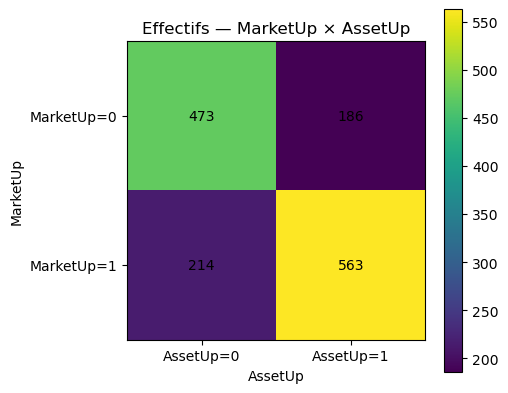

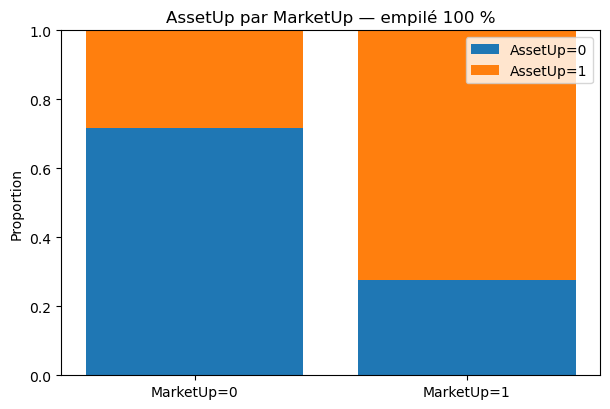

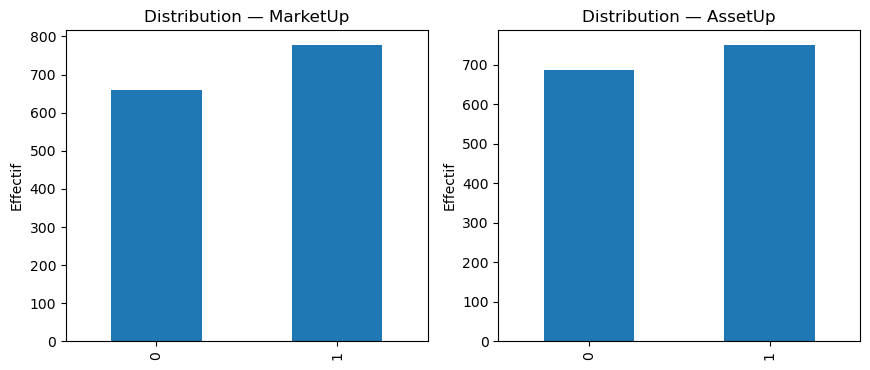

Chi2=277.823, ddl=1, p-value=0.0000, V de Cramér=0.440


In [8]:
# Variables binaires : marché en hausse / actif en hausse
mr = (market_r > 0).astype(int).rename("MarketUp")
ar = (asset_r[TARGET] > 0).astype(int).rename("AssetUp")
df_cat = pd.concat([mr, ar], axis=1).dropna()

# Tableau de contingence
cont = pd.crosstab(df_cat["MarketUp"], df_cat["AssetUp"])
display(cont)


# === VISUELS (sans résidus) ===
import matplotlib.pyplot as plt

# 1) Heatmap des effectifs observés (2x2)
fig, ax = plt.subplots(figsize=(5.2, 4.4))
im = ax.imshow(cont.values, aspect='equal')
ax.set_xticks(np.arange(cont.shape[1]))
ax.set_yticks(np.arange(cont.shape[0]))
ax.set_xticklabels([f"AssetUp={col}" for col in cont.columns])
ax.set_yticklabels([f"MarketUp={idx}" for idx in cont.index])
# Annoter les effectifs
for i in range(cont.shape[0]):
    for j in range(cont.shape[1]):
        ax.text(j, i, int(cont.values[i, j]), ha='center', va='center')
ax.set_title("Effectifs — MarketUp × AssetUp")
ax.set_xlabel("AssetUp")
ax.set_ylabel("MarketUp")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# 2) Barres empilées 100 % (AssetUp conditionnel à MarketUp)
prop = cont.div(cont.sum(axis=1), axis=0)  # proportions par ligne
fig, ax = plt.subplots(figsize=(6.2, 4.2))
bottom = np.zeros(len(prop))
x = np.arange(len(prop.index))

for j, col in enumerate(prop.columns):
    ax.bar(x, prop[col].values, bottom=bottom, label=f"AssetUp={col}")
    bottom += prop[col].values

ax.set_xticks(x)
ax.set_xticklabels([f"MarketUp={i}" for i in prop.index])
ax.set_ylim(0, 1)
ax.set_ylabel("Proportion")
ax.set_title("AssetUp par MarketUp — empilé 100 %")
ax.legend()
plt.tight_layout()
plt.show()

# 3) Marges : distributions séparées de MarketUp et AssetUp
fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.8))

# Distribution MarketUp (somme sur colonnes)
cont.sum(axis=1).plot(kind='bar', ax=axes[0])
axes[0].set_title("Distribution — MarketUp")
axes[0].set_xlabel("")
axes[0].set_ylabel("Effectif")

# Distribution AssetUp (somme sur lignes)
cont.sum(axis=0).plot(kind='bar', ax=axes[1])
axes[1].set_title("Distribution — AssetUp")
axes[1].set_xlabel("")
axes[1].set_ylabel("Effectif")

plt.tight_layout()
plt.show()

# Test du Chi-deux
from scipy import stats
import numpy as np

chi2, p, dof, exp = stats.chi2_contingency(cont)

# V de Cramér
n = cont.to_numpy().sum()
r, c = cont.shape
min_dim = max(1, min(r - 1, c - 1))  # sécurité si dimension minimale = 0
v_cramer = np.sqrt(chi2 / (n * min_dim))

print(f"Chi2={chi2:.3f}, ddl={dof}, p-value={p:.4f}, V de Cramér={v_cramer:.3f}")




## 5) Comparer deux groupes

**Objectif.** Comparer les rendements de deux groupes **indépendants** :
- **Tech** : META, AAPL, MSFT  
- **Finance** : JPM, BAC, C  

Les rendements proviennent de `asset_r` (dates × tickers), **empilés** par groupe (`stack()`), puis **alignés** et **sans valeurs manquantes**.





### Procédure
1. **Boxplot bivarié** d’ouverture (Tech vs Finance) pour visualiser médiane, dispersion et outliers.  
2. **Descriptifs** : taille (n), moyenne, écart-type ; **IC 95 %** des moyennes par groupe.  
3. **Tests d’hypothèses** :
   - **Student** (var. égales) : statistique t, p-value.  
   - **Welch** (var. inégales) : statistique t, p-value, **df de Welch**.  
   - **Mann–Whitney** (Wilcoxon rang-sum) : U et p-value (bilatéral).  




### Critères de décision & lecture
- **Seuil** usuel : α = 0,05 (adapter selon le contexte).  
- **Welch** est **la référence** si les variances ne sont pas égales (ou si le doute persiste).  
- **Student** est rapporté **à titre informatif** si normalité + variances ≈ égales.  
- **Mann–Whitney** est **robuste** si non-normalité/outliers : lire **direction** et **amplitude** avec **Cliff’s delta**.  
- **Taille d’effet** :
  - d ≈ 0,2 : faible | 0,5 : moyen | 0,8 : fort (repères indicatifs)  
  - |Cliff’s δ| ≈ 0,147 : faible | 0,33 : moyen | 0,474 : fort



### Livrables
- **Tableau** : n, moyenne, écart-type, **IC 95 %** (par groupe) ; différence et **IC 95 %** (Welch).  
- **Résultats** : Student (t, p), **Welch** (t, p, df), **Mann–Whitney** (U, p).  
- **Taille d’effet** : Cohen’s d, Hedges g, **Cliff’s delta**.  
- **Graphiques** : **boxplot** (bivarié), **KDE superposées**, **barres ± IC 95 %**.


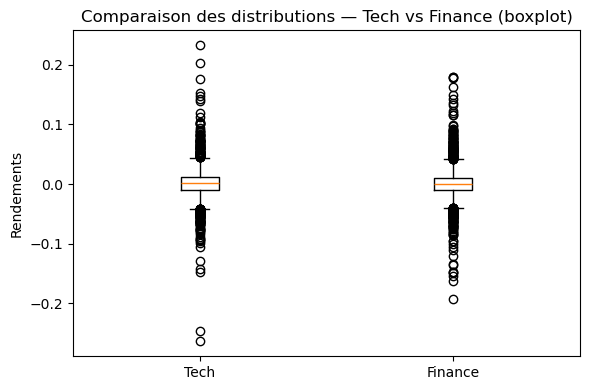

----- Résumé comparatif Tech vs Finance -----
N_tech=4308, N_fin=4308
Moyenne Tech=0.001132 | Moyenne Finance=0.000695
Std Dev Tech=0.022731 | Std Dev Finance=0.022180

--- Tests de différence de moyennes ---
Student t-test: t=0.902, p=0.36685
Welch t-test:   t=0.902, p=0.36685 (df=8608.8)
Mann–Whitney U: U=9445587.000, p=0.15007

--- Tailles d'effet ---
Cohen's d:    0.019
Hedges' g:    0.019
Cliff's delta:0.018


In [9]:
# === Comparer deux groupes : Student, Welch et Wilcoxon (rank-sum) ===
# On commence par un boxplot bivarié (Tech vs Finance).

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd # Import pandas for DataFrame

# Groupes (exemple)
group_tech = ["META","AAPL","MSFT"]
group_fin  = ["JPM","BAC","C"]

# Séries de rendements par groupe (asset_r: DataFrame dates x tickers)
# Replace this with your actual asset_r DataFrame


tech = asset_r[group_tech].stack().dropna()
fin  = asset_r[group_fin].stack().dropna()

# ---------- 1) Boxplot bivarié ----------
plt.figure(figsize=(6,4))
plt.boxplot([tech.values, fin.values], tick_labels=["Tech", "Finance"], showfliers=True) # Changed labels to tick_labels
plt.ylabel("Rendements")
plt.title("Comparaison des distributions — Tech vs Finance (boxplot)")
plt.tight_layout()
plt.show()

# ---------- 2) Tests paramétriques ----------
# Student (variances égales)
t_student, p_student = stats.ttest_ind(tech, fin, equal_var=True, nan_policy="omit")

# Welch (variances inégales)
t_welch, p_welch = stats.ttest_ind(tech, fin, equal_var=False, nan_policy="omit")

# Degrés de liberté de Welch (info utile)
n1, n2 = tech.size, fin.size
s1, s2 = tech.std(ddof=1), fin.std(ddof=1)
df_welch = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))

# ---------- 3) Test non paramétrique ----------
# Wilcoxon "rank-sum" pour groupes indépendants = Mann–Whitney U (bilatéral)
u_stat, p_mw = stats.mannwhitneyu(tech, fin, alternative="two-sided")

# Effets (optionnels)
# Cohen's d (pooled) et Hedges g (correction petit échantillon)
m1, m2 = tech.mean(), fin.mean()
pooled_var = ((n1-1)*s1**2 + (n2-1)*s2**2) / (n1 + n2 - 2)
cohen_d = (m1 - m2) / np.sqrt(pooled_var)
J = 1 - 3/(4*(n1+n2) - 9)
hedges_g = J * cohen_d

# Cliff's delta (lié à U) ~ taille d'effet rangs
cliffs_delta = (2*u_stat / (n1*n2)) - 1

# ---------- 4) Résumé ----------
print("----- Résumé comparatif Tech vs Finance -----")
print(f"N_tech={n1}, N_fin={n2}")
print(f"Moyenne Tech={m1:.6f} | Moyenne Finance={m2:.6f}")
print(f"Std Dev Tech={s1:.6f} | Std Dev Finance={s2:.6f}") # Added this line to complete the print statement

print("\n--- Tests de différence de moyennes ---")
print(f"Student t-test: t={t_student:.3f}, p={p_student:.5f}")
print(f"Welch t-test:   t={t_welch:.3f}, p={p_welch:.5f} (df={df_welch:.1f})")
print(f"Mann–Whitney U: U={u_stat:.3f}, p={p_mw:.5f}")

print("\n--- Tailles d'effet ---")
print(f"Cohen's d:    {cohen_d:.3f}")
print(f"Hedges' g:    {hedges_g:.3f}")
print(f"Cliff's delta:{cliffs_delta:.3f}")

## 6) Comparer plusieurs groupes (ANOVA + Kruskal)

**Objectif.** Tester si les **moyennes** (ou distributions) de **plus de deux groupes** diffèrent de manière significative  
(ex. secteurs : Tech, Finance, Énergie ; ou tranches de PD ; ou régimes de marché).


### Quand utiliser quoi ?
- **ANOVA à 1 facteur (classique)** : données **numériques continues**, groupes **indépendants**,  
  **normalité** raisonnable **dans chaque groupe** et **homogénéité des variances** (≈ Levene OK).
- **Welch ANOVA / Brown–Forsythe** : normalité OK mais **variances inégales** et/ou tailles différentes.
- **Kruskal–Wallis (non paramétrique)** : **non-normalité**, **outliers lourds**, données **ordinales**.
- **Mesures répétées** : si les observations sont **corrélées** (mêmes entités à travers conditions),  
  envisager **ANOVA à mesures répétées** / **Friedman** (au lieu d’ANOVA/Kruskal simples).



### Hypothèses (versions indépendantes)
- **H0** : toutes les moyennes (ANOVA) ou distributions (Kruskal) sont **égales** entre groupes.  
- **H1** : au moins un groupe **diffère** des autres.  
- Observations **indépendantes** entre groupes.



### Préparation des données
1. Définir les **groupes** (étiquettes claires, ≥ 2 niveaux ; idéalement ≥ 3).  
2. **Nettoyer** : outliers extrêmes (winsorisation légère si besoin), valeurs manquantes.  
3. **Vérifier** : normalité par groupe (QQ-plot, Shapiro) et **égalité des variances** (Levene).  
4. Garder des **tailles raisonnables** par groupe (éviter les groupes trop petits).



### Procédure (sans formules)
1. **Visualiser en premier** : **boxplots** multi-groupes (ordre par médiane), éventuellement **violins** ou **densités**.  
2. **Test global** :  
   - ANOVA (classique) si normalité + variances ≈ égales.  
   - **Welch ANOVA** si variances inégales.  
   - **Kruskal–Wallis** si non-normalité/ordinal/outliers.  
3. Si le test global est **significatif** → **post-hoc** pour identifier **quels** groupes diffèrent.



### Post-hoc (comparaisons multiples)
- **Après ANOVA (variances ≈ égales)** : **Tukey HSD** (gère tailles inégales, suppose homoscédasticité).  
- **Après Welch ANOVA (variances inégales)** : **Games–Howell** (pas d’égalité de variances requise).  
- **Après Kruskal–Wallis** : **Dunn** (ou Conover) avec **correction** (Holm, Bonferroni, BH/FDR).



### Taille d’effet (à rapporter avec IC si possible)
- **ANOVA** : **η² (eta squared)**, **η² partielle** ou **ω² (omega squared)**.  
  - Repères (indicatifs) : η² ≈ 0,01 faible | 0,06 moyen | 0,14 fort.  
- **Kruskal** : **ε² (epsilon squared)** ou **η²(H)** comme approximation.



### Visualisations utiles
- **Boxplots** par groupe (ordre par médiane, mêmes axes).  
- **Barres ± IC** des **moyennes** (ou **médianes** pour Kruskal) par groupe.  
- **Densités** superposées ou **ridgelines** (si utile).  
- **Diagrammes de post-hoc** (matrice des p-values ajustées).



### Pièges à éviter
- **Groupes dépendants** traités comme indépendants (utiliser mesures répétées/Friedman).  
- **Multiplicité** non contrôlée (toujours ajuster les p-values post-hoc).  
- **Déséquilibre extrême** des tailles d’échantillon (prudence dans l’interprétation).  
- **Hétéroscédasticité** ignorée (préférer **Welch ANOVA** ou **Games–Howell**).



### Livrables attendus
- **Résumé par groupe** : n, moyenne/écart-type (ou médiane/IQR).  
- **Test global** : ANOVA/Welch ANOVA/Kruskal (statistique, ddl si pertinent, p-value).  
- **Post-hoc** : p-values **ajustées**, paires significatives, **taille d’effet**.  
- **Graphiques** : **boxplots** multi-groupes + **barres ± IC**, **matrice post-hoc** (option).


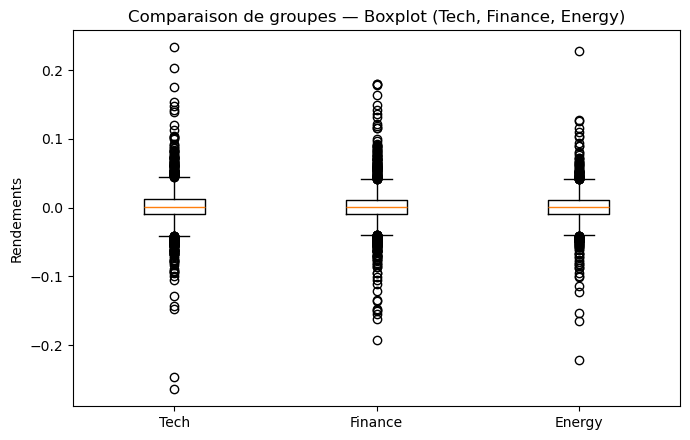

Normalité (Shapiro) Tech: W=0.889, p=0.00000 → NON
Normalité (Shapiro) Finance: W=0.881, p=0.00000 → NON
Normalité (Shapiro) Energy: W=0.901, p=0.00000 → NON
Levene (variances égales ?) : W=1.874, p=0.15350 → OK
ANOVA une voie : F=0.554, p=0.57480
Kruskal–Wallis : H=2.169, p=0.33804


In [10]:
# === Boxplot + tests : ANOVA, Kruskal–Wallis, normalité (Shapiro) et Levene ===

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1) Groupes
group_tech   = ["META", "AAPL", "MSFT"]
group_fin    = ["JPM", "BAC", "C"]
group_energy = ["XOM", "CVX"]


tech   = asset_r[group_tech].stack().dropna().values
fin    = asset_r[group_fin].stack().dropna().values
energy = asset_r[group_energy].stack().dropna().values

groups = [tech, fin, energy]
labels = ["Tech", "Finance", "Energy"]
alpha  = 0.05

# 2) Boxplot multigroupes
plt.figure(figsize=(7, 4.5))
plt.boxplot(groups, tick_labels=labels, showfliers=True) # Changed labels to tick_labels
plt.ylabel("Rendements")
plt.title("Comparaison de groupes — Boxplot (Tech, Finance, Energy)")
plt.tight_layout()
plt.show()

# 3) Normalité par groupe (Shapiro–Wilk)
for lab, g in zip(labels, groups):
    W, p = stats.shapiro(g)
    print(f"Normalité (Shapiro) {lab}: W={W:.3f}, p={p:.5f} → {'OK' if p>alpha else 'NON'}")

# 4) Égalité des variances (Levene, robuste)
W_lev, p_lev = stats.levene(*groups, center='median')
print(f"Levene (variances égales ?) : W={W_lev:.3f}, p={p_lev:.5f} → {'OK' if p_lev>alpha else 'NON'}")

# 5) Tests globaux
# ANOVA (classique, suppose normalité + variances ≈ égales)
F, pA = stats.f_oneway(*groups)
print(f"ANOVA une voie : F={F:.3f}, p={pA:.5f}")

# Kruskal–Wallis (non paramétrique, rangs)
H, pK = stats.kruskal(*groups)
print(f"Kruskal–Wallis : H={H:.3f}, p={pK:.5f}")

## Défi — Comparer 4 groupes

### Groupes
- **Tech** : META, AAPL, MSFT  
- **Finance** : JPM, BAC, C  
- **Énergie** : XOM, CVX  
- **Santé** : JNJ, PFE, UNH

### À faire
1. **Boxplot** des 4 groupes (rendements empilés par secteur).  
2. **Tests préalables** :  
   - Normalité par groupe (**Shapiro**).  
   - Égalité des variances (**Levene**, center = median).  
3. **Test global (choisir selon les tests préalables)** :  
   - **ANOVA** si normalité OK **et** Levene OK.  
   - **Welch-ANOVA** si normalité OK **mais** Levene NON.  
   - **Kruskal–Wallis** si normalité NON.  
4. **Conclusion courte** : indiquer si une différence globale existe (p-value) et résumer l’implication métier en 2–3 phrases.

### Livrables
- 1 **figure** : boxplot des 4 groupes.  
- **p-value** du test global (ANOVA ou Welch-ANOVA ou Kruskal).  
- **2–3 lignes** de conclusion.



##  Solution


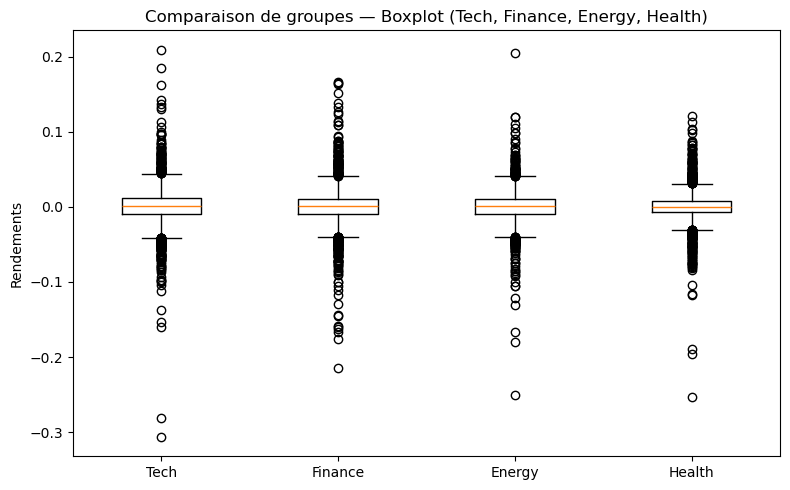


--- Tests sur les 4 groupes ---
Normalité (Shapiro) Tech: W=0.883, p=0.00000 → NON
Normalité (Shapiro) Finance: W=0.880, p=0.00000 → NON
Normalité (Shapiro) Energy: W=0.895, p=0.00000 → NON
Normalité (Shapiro) Health: W=0.859, p=0.00000 → NON
Levene (variances égales ?) : W=53.705, p=0.00000 → NON
ANOVA  : F=0.980, p=0.40115
Welch-ANOVA : F=1.057, p=0.36606
Kruskal–Wallis : H=8.025, p=0.04550


In [11]:
# ============================================================
# Yahoo Finance (univers fourni) → Boxplot + Shapiro + Levene
# + ANOVA, Welch-ANOVA, Kruskal — pour 4 groupes sectoriels
# Prérequis (une fois) : pip install yfinance statsmodels
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.oneway import anova_oneway  # Welch-ANOVA
import yfinance as yf

# -------- 1) Télécharger les PRIX depuis Yahoo Finance --------
tickers = ["META","AAPL","MSFT","JPM","BAC","C","XOM","CVX","JNJ","PFE","UNH"]

UNIVERSE = tickers
MARKET_TICKER = "^GSPC"
START_DATE = "2020-01-01"
END_DATE = None  # jusqu'à aujourd'hui

data = yf.download(UNIVERSE + [MARKET_TICKER],
                   start=START_DATE, end=END_DATE,
                   progress=False, auto_adjust=False)

# Extraire les prix ajustés (gère le MultiIndex de yfinance)
if isinstance(data.columns, pd.MultiIndex):
    prices = data["Adj Close"].copy()
else:
    prices = data[["Adj Close"]].copy()

prices = prices.dropna(how="all")
market_prices = prices[MARKET_TICKER].dropna()
asset_prices  = prices.drop(columns=[MARKET_TICKER], errors="ignore").dropna(how="all")

# -------- 2) Rendements (log) --------
asset_r  = np.log(asset_prices).diff().dropna(how="all")
market_r = np.log(market_prices).diff().dropna()

# -------- 3) Définir 4 groupes (présents dans l'univers) --------
group_tech   = ["META", "AAPL", "MSFT"]
group_fin    = ["JPM", "BAC", "C"]
group_energy = ["XOM", "CVX"]
group_health = ["JNJ", "PFE", "UNH"]

tech   = asset_r[group_tech].stack().dropna().values
fin    = asset_r[group_fin].stack().dropna().values
energy = asset_r[group_energy].stack().dropna().values
health = asset_r[group_health].stack().dropna().values

groups = [tech, fin, energy, health]
labels = ["Tech", "Finance", "Energy", "Health"]
alpha  = 0.05

# -------- 4) Boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(groups, tick_labels=labels, showfliers=True)
plt.ylabel("Rendements")
plt.title("Comparaison de groupes — Boxplot (Tech, Finance, Energy, Health)")
plt.tight_layout()
plt.show()

# -------- 5) Tests
print("\n--- Tests sur les 4 groupes ---")

# Normalité par groupe (Shapiro–Wilk)
for lab, g in zip(labels, groups):
    W, p = stats.shapiro(g)
    print(f"Normalité (Shapiro) {lab}: W={W:.3f}, p={p:.5f} → {'OK' if p>alpha else 'NON'}")

# Égalité des variances (Levene, robuste)
W_lev, p_lev = stats.levene(*groups, center='median')
print(f"Levene (variances égales ?) : W={W_lev:.3f}, p={p_lev:.5f} → {'OK' if p_lev>alpha else 'NON'}")

# Tests globaux
# ANOVA (classique, suppose normalité + variances ≈ égales)
F, pA = stats.f_oneway(*groups)
print(f"ANOVA  : F={F:.3f}, p={pA:.5f}")

# Welch-ANOVA (ne suppose PAS variances égales)
# anova_oneway returns a tuple, so extract the F-value and p-value by index
welch_anova_result = anova_oneway(groups, use_var="unequal")
F_welch, p_welch = welch_anova_result[0], welch_anova_result[1] # Access by index
print(f"Welch-ANOVA : F={F_welch:.3f}, p={p_welch:.5f}")

# Kruskal–Wallis (non paramétrique, rangs)
H, pK = stats.kruskal(*groups)
print(f"Kruskal–Wallis : H={H:.3f}, p={pK:.5f}")